# Greedy Learner - Step 2
Step 2: Optimization algorithm. Formally state the optimization problem where the objective function is the maximization of the cumulative expected margin over all the products. Design a greedy algorithm to optimize the objective function when all the parameters are known. The algorithm works as follows. At the beginning, every item is associated with the corresponding lowest price. Then, evaluate the marginal increase obtained when the price of a single product is increased by a single level, thus considering 5 potential different price configurations at every iteration, and choose the price configuration providing the best marginal increase (a price configuration specifies the price of every product). The algorithm stops when no new configuration among the 5 evaluated is better than the previous one. For instance, at the beginning, evaluate the 5 price configurations in which all the products are priced with the lowest price except for one product which is priced with the second lowest price. If all these price configurations are worse than the configuration in which all the products are priced with the lowest price, stop the algorithm and return the configuration with the lowest price for all the products. Otherwise, choose the best price configuration and re-iterate the algorithm. Notice that the algorithm monotonically increases the prices as well as the cumulative expected margin. Therefore, the algorithms cannot cycle. However, there is not guarantee that the algorithm will return the optimal price configuration. Develop the algorithm by Python.


### 1. Greedy Learner Structure

##### __init()__ 
This method initializes the learner parameters.

In [ ]:
import numpy as np
'''
    - configuration_margin[]: margins of the five possible different derivation obtained from a starting configuration
    - t: counter variable
    - optimal_configuration[]: current optimal price configuration found
    - optimal_configuration_margin: margin of the current optimal configuration
    - isOptima: Flag used to signal whether the optimal configuration has been found by the learner
    - debug: flag used for debugging purpose
'''
def __init__(self, debug=False):
        self.configuration_margin = [0, 0, 0, 0, 0] 
        self.t = -1 
        self.optimal_configuration = [0, 0, 0, 0, 0]  
        self.optimal_configuration_margin = 0   
        self.isOptima = False
        self.debug = debug

##### __pull_arm()__
This method returns the new price configuration that has to be evaluated. It pulls a new arm of the optimal configuration and returns the new one.  
<br>starting configuration: [0, 0, 0, 0, 0]

<br>possible derivations:   
[1, 0, 0, 0, 0]                  
[0, 1, 0, 0, 0]                            
[0, 0, 1, 0, 0]                            
[0, 0, 0, 1, 0]                            
[0, 0, 0, 0, 1]

In [ ]:
def pull_arm(self):
        if self.t == -1 or self.isOptima:
            return self.optimal_configuration

        try_configuration = self.optimal_configuration.copy()

        # Can't try arm above 3
        if try_configuration[self.t] < 3:
            try_configuration[self.t] += 1

        return try_configuration

##### __update(overallMargin)__ 
This procedure takes as input the `overallMargin` of the configuration that has been evaluated (by an evaluation method external to the learner class), and stores it `configuration_margin[]`. 
<br> When `self.t=5` all derivations have been tested and the procedure selects the most promising one by choosing the price configuration that provides the highest margin.
<br> If the new margin is higher that the current `optimal_configuration_margin` and `isOptima=False` (the optima hasn't been found yet), the learner updates `optimal_configuration_margin` with the new value and the `optimal_configuration[]` is updated with the new arm.

In [ ]:
def update(self, overallMargin):
        # print(overallMargin)
        if self.t == -1:
            self.optimal_configuration_margin = overallMargin
            self.t += 1
            return

        # Set margin to 0 if the arm was not changed, so if the optimal configuration arm is already at 3
        # This is done to not compare again the optimal configuration with the other derivation, since if the arm is at
        # 3 it was not increased in the pull arm phase.
        if self.optimal_configuration[self.t] != 3:
            self.configuration_margin[self.t] = overallMargin
        else:
            self.configuration_margin[self.t] = 0

        self.t += 1

        # If t==5 we have tried all derivation and must update the optimal margin and configuration (if any are better)
        if self.t == 5:
            result = np.where(self.configuration_margin == np.amax(self.configuration_margin))
            result = result[0]
            result = np.random.choice(result)

            if np.amax(self.configuration_margin) > self.optimal_configuration_margin and not self.isOptima:
                if self.optimal_configuration[result] < 3:
                    self.optimal_configuration[result] += 1
                self.optimal_configuration_margin = np.amax(self.configuration_margin)
                if self.debug:
                    print(self.configuration_margin, self.optimal_configuration_margin, self.optimal_configuration)
            else:
                self.isOptima = True
                if self.debug:
                    print(self.configuration_margin, self.optimal_configuration_margin, self.optimal_configuration)
            self.t = 0

### 2. Greedy Learner behavior
1. The learner is initialized with the base-configuration in which all the products are priced with the lowest price: [0, 0, 0, 0, 0].
2. An _evaluation policy_ is employed in order to assign an __overall margin__ to the configuration. Different possible margin evaluation policies can be used to assign a margin to the configuration.
3. `update(overallMargin)` procedure of the learner is invoked
4. Method `pullArm()` of the learner sets the new configuration to be evaluated.
5. Repeat steps 2-3-4 untill an _exit condition_ is met

### 3. Greedy Learner sub-optimality
Although coputationally cheap the greedy approach is characterized by the major drawback of being extremely susceptible to <font color='green'>__local optimums__</font>. <br> The greedy approach is not guaranteed to return the __price configuration__ that is the <font color='green'>__global optima__</font>, indeed the learner may quickly find a single configuration that grants an immediate better margin than the other configurations belonging to the same level. By developing that configuration and by discarding the others, the learner might miss the opportunity to reach a final configuration with an overall better margin. This particular situation is further explained in the picture below:

![local_optima](greedy_learner_local_optima.PNG)

### Load different configurations

In [2]:
import json
from Environment import Environment
import numpy as np
from Learner.BruteForce import *
from Model.UserClass import *
from Model.Product import *
from Model.GraphProbabilities import *
from Model.Evaluator.GraphEvaluator import GraphEvaluator
from Model.Evaluator.Baseline import Baseline

def load_config(file_path):
    f = open(file_path)
    config = json.load(f)
    f.close()
    uc = config["classes"][0]

    productList = [Product(int(key), uc["secondary"][key]) for key in uc["secondary"]]

    conversionRateLevels = uc["conversionRates"]
    marginsPerPrice = config["margins"]
    click_prob = uc["clickProbability"]
    lambda_p = uc["lambda"]
    alphas = uc["alphas"]
    units_mean = uc["unitsShape"]
    num_prices = len(conversionRateLevels[0])
    num_prods = len(alphas)
    usersMean = uc["usersMean"]
    usersVariance = uc["usersVariance"]

    optimal_arm = []

    pulledArm = [0, 3, 0, 2, 0] # [3, 2, 0, 3, 2] 
    margins = []
    convRates = []
    configuration = {"productList": productList, "conversionRateLevels": conversionRateLevels, "marginsPerPrice": marginsPerPrice, 
                    "click_prob": click_prob, "lambda_p": lambda_p, "alphas": alphas, "units_mean": units_mean, "num_prices": num_prices, 
                    "num_prods": num_prods, "optimal_arm": optimal_arm, "pulledArm": pulledArm, "margins": margins, "convRates": convRates,
                    "usersMean": usersMean, "usersVariance": usersVariance}
    return configuration

### Run simulation for each evaluation method
In order to answer to the following question: how the evaluation method impacts the solution search?

In [ ]:
# For each config file choosen run the simulation with different evaluation method, that are GraphEvaluator, Baseline and Environment one
# Use markdown to explain how different evaluation methods works

#### Evaluation method: Baseline evaluation

In [ ]:
from Model.Evaluator.Baseline import Baseline
from Learner.GreedyLearner import *
 
config = load_config('./Configs/config1.json')
greedyLearner = GreedyLearner(debug=True)
 
pulledArm = greedyLearner.pull_arm()
previousConfig = []
while pulledArm != previousConfig:
   print("pulledArm: ", pulledArm)
   armMargins = []
   armConvRates = []
   for k in range(0, len(pulledArm)):
       armMargins.append(config["marginsPerPrice"][k][pulledArm[k]])
       armConvRates.append(config['conversionRateLevels'][k][pulledArm[k]])
  
   # Initialization of Baseline evaluator object:
   baselineEval = Baseline(products_list=config['productList'], click_prob_matrix=config['click_prob'], lambda_prob=config['lambda_p'],
               alphas=config['alphas'], conversion_rates=armConvRates, margins=armMargins, units_mean=config['units_mean'], verbose=True)
 
   # Price configuration evaluation and greedy Learner margin update:
   margin = baselineEval.computeMargin()
   greedyLearner.update(margin)
 
   previousConfig = pulledArm
   pulledArm = greedyLearner.pull_arm()
 
print("Optimal configuration: {}\n Optimal configuration's margin: {}".format(greedyLearner.optimal_configuration, greedyLearner.optimal_configuration_margin))
 


#### Evaluation method: Graph evaluation

In [3]:
from Learner.GreedyLearner import *
 
config = load_config('./Configs/Config1.json')
greedyLearner = GreedyLearner(debug=True)
 
pulledArm = greedyLearner.pull_arm()
previousConfig = []
while pulledArm != previousConfig:
   armMargins = []
   armConvRates = []
   for k in range(0, len(pulledArm)):
       armMargins.append(config["marginsPerPrice"][k][pulledArm[k]])
       armConvRates.append(config['conversionRateLevels'][k][pulledArm[k]])
  
   # Initialization of GraphEvaluator object:
   graphEval = GraphEvaluator(products_list=config['productList'], click_prob_matrix=config['click_prob'], lambda_prob=config['lambda_p'],
               alphas=config['alphas'], conversion_rates=armConvRates, margins=armMargins, units_mean=config['units_mean'], verbose=True)
 
   # Price configuration evaluation and greedy Learner margin update:
   margin = graphEval.computeMargin()
   print("Configuration: {}, configurationMargin: {}".format(pulledArm, margin) )
 
   greedyLearner.update(margin)
 
   previousConfig = pulledArm
   pulledArm = greedyLearner.pull_arm()
 
print("Optimal configuration: {}\n Optimal configuration's margin: {}".format(greedyLearner.optimal_configuration, greedyLearner.optimal_configuration_margin))

[[0.0, 0.35, 0.294, 0.0, 0.0], [0.0, 0.0, 0.36000000000000004, 0.0, 0.126], [0.0, 0.0, 0.0, 0.7200000000000001, 0.44099999999999995], [0.336, 0.0, 0.0, 0.0, 0.4], [0.0, 0.81, 0.0, 0.189, 0.0]]
Reached nodes in 1-step: 1; 2; 
Reached nodes in 2-step: 2; 3; 4; 
Reached nodes in 3-step: 1; 3; 4; 
Reached nodes in 4-step: 1; 3; 4; 
Expected value margin for product 0 as starting is 40 

Reached nodes in 1-step: 2; 4; 
Reached nodes in 2-step: 3; 4; 
Reached nodes in 3-step: 0; 3; 4; 
Reached nodes in 4-step: 0; 2; 
Expected value margin for product 1 as starting is 29 

Reached nodes in 1-step: 3; 4; 
Reached nodes in 2-step: 0; 1; 3; 4; 
Reached nodes in 3-step: 0; 1; 
Reached nodes in 4-step: 1; 4; 
Expected value margin for product 2 as starting is 23 

Reached nodes in 1-step: 0; 4; 
Reached nodes in 2-step: 1; 2; 
Reached nodes in 3-step: 2; 4; 
Reached nodes in 4-step: 1; 4; 
Expected value margin for product 3 as starting is 35 

Reached nodes in 1-step: 1; 3; 
Reached nodes in 2-st

#### Evaluation method: Environment simulation 

Configuration: [0, 0, 0, 0, 0], configurationMargin: 4.562910666853068
Configuration: [1, 0, 0, 0, 0], configurationMargin: 4.8294167016365925
Configuration: [0, 1, 0, 0, 0], configurationMargin: 5.830158285474156
Configuration: [0, 0, 1, 0, 0], configurationMargin: 5.044097076514198
Configuration: [0, 0, 0, 1, 0], configurationMargin: 5.208629583159069
Configuration: [0, 0, 0, 0, 1], configurationMargin: 4.709621993127147
[4.8294167016365925, 5.830158285474156, 5.044097076514198, 5.208629583159069, 4.709621993127147] 5.830158285474156 [0, 1, 0, 0, 0]
Configuration: [1, 1, 0, 0, 0], configurationMargin: 5.2910223217409555
Configuration: [0, 2, 0, 0, 0], configurationMargin: 6.7322886856983315
Configuration: [0, 1, 1, 0, 0], configurationMargin: 5.739665388637156
Configuration: [0, 1, 0, 1, 0], configurationMargin: 5.963487280117738
Configuration: [0, 1, 0, 0, 1], configurationMargin: 5.353335661893119
[5.2910223217409555, 6.7322886856983315, 5.739665388637156, 5.963487280117738, 5.3533

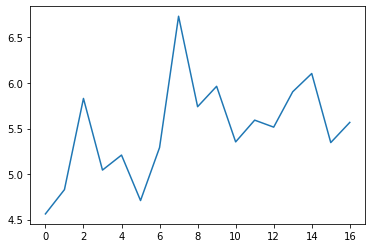

In [4]:
import matplotlib.pyplot as plt
from Learner.GreedyLearner import *

def totalMarginPerEpisode(envReturn, marginsPerPrice, pulledArm):
   TotMargin = 0
   for e in envReturn:
       if e.bought:
           TotMargin += marginsPerPrice[e.product][pulledArm[e.product]] * e.units
   return TotMargin
 
 
config = load_config('./Configs/Config1.json')
environment = Environment(config_path="./Configs/Config2.json")
greedyLearner = GreedyLearner(debug=True)
 
pulledArm = greedyLearner.pull_arm()
environment.setPriceLevels(pulledArm)
environmentRoundResult = environment.round()

n_experiment = 200
totalUsers = 0

previousConfig = []
allMargins = []
while pulledArm != previousConfig:
    cumulativeConfigurationMargin = 0
    totalUsers = 0
    for k in range(0, n_experiment):
        cumulativeConfigurationMargin += totalMarginPerEpisode(environmentRoundResult["episodes"], config["marginsPerPrice"], pulledArm)
        totalUsers += environmentRoundResult["roundUsers"]
        environmentRoundResult = environment.round()
 
    average_configuration_margin = ((cumulativeConfigurationMargin / n_experiment) / totalUsers) * 100
    print("Configuration: {}, configurationMargin: {}".format(pulledArm, average_configuration_margin))

    allMargins.append(average_configuration_margin)
    greedyLearner.update(average_configuration_margin)
    
    previousConfig = pulledArm
    pulledArm = greedyLearner.pull_arm()

print("Optimal configuration: {}\n Optimal configuration's margin: {}".format(greedyLearner.optimal_configuration, greedyLearner.optimal_configuration_margin))

print("Optima", greedyLearner.optimal_configuration)
print("Optima margin", greedyLearner.optimal_configuration_margin)
print("allMargins", allMargins)

fig, ax = plt.subplots()
ax.plot(allMargins)
plt.show()

   


#### Plot the results

In [ ]:
# Plot the expected reward using matplotlib in a bar chart (so in total 3 close bars for each configuaration)

### Run simulation with specific evaluation but different learner (BruteForce vs GreedyLearner)
In order to answer to the question, is the solution found by the Greedy the optimal one?

In [ ]:
# Fix the evaluator as GraphEvaluator and check how the optimal reward differ in the two classes

#### Plot the results

In [ ]:
# As before use bar charts (2 bars for the learners for each configuration)